In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd 'drive/MyDrive/Psychia/'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Psychia/'
/content


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### General Training RoadMap
- Choose readily available LLaMA chatbot
- Train in-context with convestational therapy dataet, 1k lines
- Connect with DSM-5 document using langChain

In [3]:
%%capture
%pip install accelerate peft bitsandbytes transformers trl langchain ctransformers sentence_transformers faiss-cpu

NOTE: You must restart the kernel after this step, or else some of the packages will bug. Sorry ;(

In [3]:
import os
import torch
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    pipeline,
    logging,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

Make sure to change new_model to be the correct name of whatever directory you want to make!!!

In [4]:
# GPT2 Hugging Face Model
base_model = "gpt2"

# Conversational Therapy Dataset
counseling_dataset = "Amod/mental_health_counseling_conversations"

new_model = "gpt2-psychia"  #CHANGE THIS TO BE THE CORRECT DIRECTORY FOR TUNING

In [5]:

from datasets import load_dataset
from sklearn.model_selection import train_test_split
counseling_dataset = "Amod/mental_health_counseling_conversations"
def format_data(sample):
  return f"""
You are a therapist addressing the concerns of a patient and answering any questions they may have.

### Question:
{sample["Context"]}

### Response:
{sample["Response"]}
"""

data = [format_data(d) for d in load_dataset(counseling_dataset, split='train')]

print(f"Dataset Size: {len(data)}")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset Size: 3512


In [6]:
# Load model
model = GPT2LMHeadModel.from_pretrained('gpt2', device_map={"": 0})

model.config.use_cache = False


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [7]:
# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [8]:
train_data, val_data = train_test_split(data, test_size=0.1, random_state=50)
train_data = [tokenizer(line, padding=True, max_length=1024, truncation=True) for line in train_data]
val_data = [tokenizer(line, padding=True, max_length=1024, truncation=True) for line in val_data]

In [9]:
from transformers import set_seed
sample = data[0]
set_seed(70)


input = tokenizer(f'''You are a therapist addressing the concerns of a patient and answering any questions they may have.

### Question:
I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?

### Response:''', return_tensors='pt')
input.to(model.device)

output = model.generate(**input, max_new_tokens=200, do_sample=True, temperature = 0.9, top_k=30, top_p=0.95, num_return_sequences=1)[0]

print(f"Instruction and Ground Truth Response:\n{sample}\n")
print(tokenizer.decode(output, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruction and Ground Truth Response:

You are a therapist addressing the concerns of a patient and answering any questions they may have.

### Question:
I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?

### Response:
If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media.  Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to 

In [10]:
# LoRA config based on QLoRA paper
peft_config = LoraConfig(
    lora_alpha=64,
    lora_dropout=0.1,
    r=32,
    bias="none",
    task_type="CAUSAL_LM",
)
# Prepare model for training
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,179,648 || all params: 125,619,456 || trainable%: 0.939064725769868


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:336: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [11]:
args = TrainingArguments(
    output_dir=new_model,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    save_strategy="steps",
    evaluation_strategy="steps",
    learning_rate=2e-4,
    fp16=True,
    warmup_steps=100,
    max_steps=500,
    eval_steps=50,
    save_steps=100,
    logging_steps = 1,
    lr_scheduler_type="constant",
    disable_tqdm=False
)

In [12]:
max_seq_length = 1024 # max sequence length for model and packing of the dataset


seed = 70
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    args=args,
)


In [ ]:
# Train
trainer.train()


Step,Training Loss,Validation Loss
50,3.174800,2.906793
100,2.865300,2.819323
150,2.941900,2.795202


In [ ]:
set_seed(70)
model_numbers = [100, 200, 500]
models = [GPT2LMHeadModel.from_pretrained(new_model + "/checkpoint-100"), GPT2LMHeadModel.from_pretrained(new_model + "/checkpoint-200"), GPT2LMHeadModel.from_pretrained(new_model + "/checkpoint-500")]
sample = data[0]


In [ ]:
input = tokenizer(f'''You are a therapist addressing the concerns of a patient and answering any questions they may have.

### Question:
I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?

### Response:''', return_tensors='pt')
for i in range(3):
  m = models[i]
  n = model_numbers[i]
  output = m.generate(**input, max_new_tokens=200, do_sample=True, temperature = 0.9, top_k=30, top_p=0.95, num_return_sequences=1)[0] #these hyperparams??? idk man
  print(f"\n Model at step:{n}\n")
  print(tokenizer.decode(output, skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 Model at step:100

You are a therapist addressing the concerns of a patient and answering any questions they may have.

### Question:
I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?

### Response:
Many therapists and therapists have been in talks with your family regarding suicide. Many times, counselors will share with you that some of these thoughts can't be alleviated if someone else tries to make the same decisions as you. You need to be able to make the best decisions for yourself. It is possible, however, for your family members to be able to offer the best care, support and support you and others need to make it through the painful time you struggle with feelings and self-criticism.    Counselors and 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 Model at step:200

You are a therapist addressing the concerns of a patient and answering any questions they may have.

### Question:
I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.
   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.
   How can I change my feeling of being worthless to everyone?

### Response:
Hello,  I'm sorry you have to worry about your feelings of feeling worthless.  I hope you are feeling positive about yourself and your life now and how much you are worth.  I feel so grateful and grateful to you for accepting that you are not just a worthless person.  I hope you will learn from this experience.  If you have been struggling with depression, anxiety, thoughts of suicide, etc. you may find it helpful to get a mental health counselor to help you.  If you are a friend who is able to help you find a ment

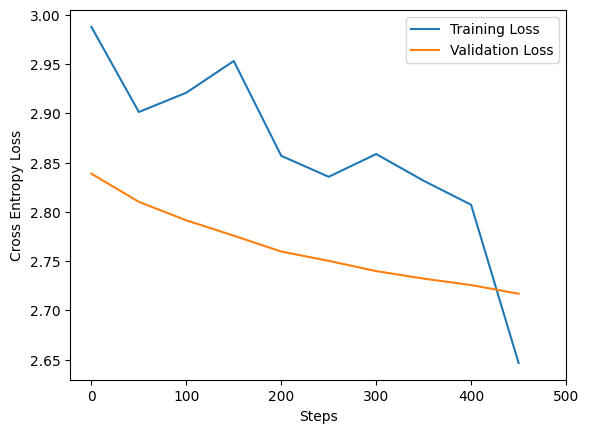

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
eval_losses = [t['eval_loss'] for t in trainer.state.log_history[50::51]]
train_losses = [t['loss'] for t in trainer.state.log_history[49::51]]
np.save(new_model + "/trainloss.npy", np.array(train_losses))
np.save(new_model + "/evalloss.npy", np.array(eval_losses))


plt.plot(train_losses, label="Training Loss")
plt.plot(eval_losses, label="Validation Loss")
plt.xlabel("Steps")
plt.xticks([0, 2, 4, 6, 8, 10], [0, 100, 200, 300, 400, 500])
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()